# ガウス混合モデル

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [3]:
from sklearn.datasets.samples_generator import make_blobs

In [4]:
X, y_true = make_blobs(n_samples=400, centers=4,
                                           cluster_std=0.60, random_state=0)
X = X[:, ::-1]

In [5]:
from sklearn.cluster import KMeans

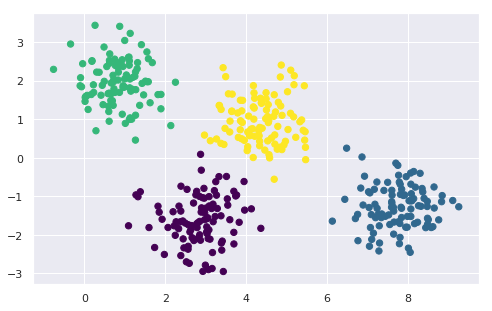

In [6]:
kmeans = KMeans(4, random_state=0)
labels =kmeans.fit(X).predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [7]:
from scipy.spatial.distance import cdist

In [8]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    plt.figure(figsize=(8, 5))
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

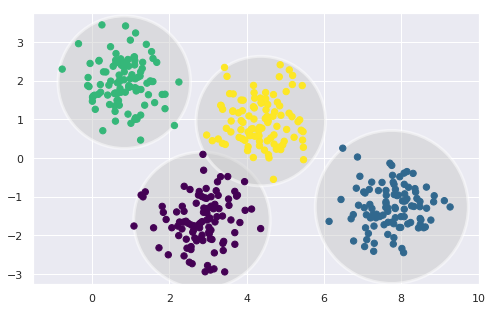

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

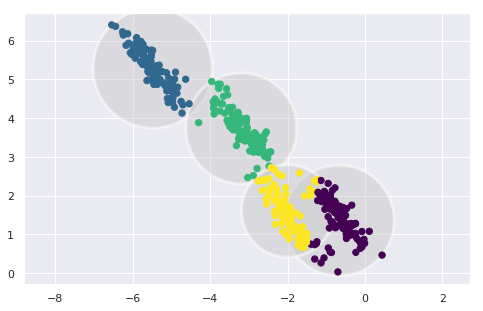

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

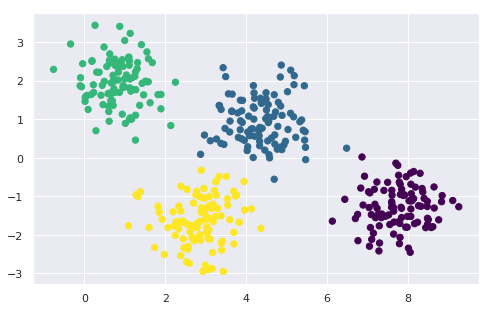

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [52]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.    0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


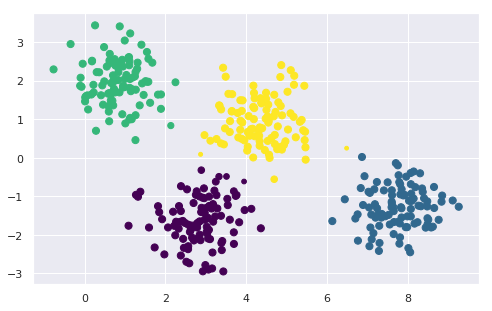

In [53]:
size = 50 * probs.max(1) ** 2
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=size, cmap='viridis')

In [17]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # 共分散を主軸に変換
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 楕円を描く
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(8, 5))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_ , gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

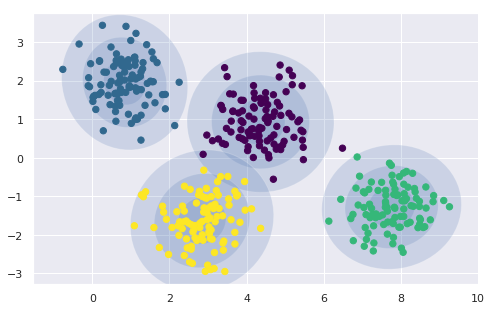

In [18]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)